In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np, os, sys
from pylab import *
sys.path.append('../modules/')
import fisher_tools

In [5]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'
from matplotlib.patches import Ellipse

## Line fitting parameters:
* ## $y = ax+b$

In [26]:
#parameters
afid, bfid = 1., 0.
astep, bstep = 0.01, 0.01
params = ['a', 'b']
fix_params = []

which_param_to_constrain = params
for p in params:
    if p in which_param_to_constrain: continue
    fix_params.append(p)
param_dict = {}
param_dict['a'] = [afid, 0.3] #fid, delta for axis limits
param_dict['b'] = [bfid, 0.3] 

In [52]:
#data 
reclen = 5#2 #00 #100
x = np.arange(reclen)#-reclen/2, reclen/2)
if (1):
    x = np.asarray( [-1, 1, 0] ) #np.arange(reclen)
    x = np.asarray( [-1, 1, 1] ) #np.arange(reclen)
    x = np.asarray( [-2, -1, 0, 1, 2, 3] ) #np.arange(reclen)
    reclen = len(x)
std_error = 0.1 #sqrt(variance) in each observed poin
errors = np.zeros(reclen) + std_error  

In [105]:
#get derivatives now
der_dic = {}
der_dic['a'] = np.zeros(reclen) + x
der_dic['b'] = np.zeros(reclen) + 1.
'''
for p in params:
    if p == 'a':
        delta = astep
        a1, a2 = afid - astep, afid + astep
        b1, b2 = bfid, bfid
    elif p == 'b':
        delta = bstep
        a1, a2 = afid, afid
        b1, b2 = bfid - bstep, bfid + bstep
    der_dic[p] = ( get_model(x, a2, b2) - get_model(x, a1, b1) ) / (2 * delta)
'''
if (0):
    for p in params:
        plot(der_dic[p], label = r'%s' %(p))
    legend(loc = 1)
    show()

In [106]:
#Fisher matrix
param_combinations = []
for pcnt,p in enumerate(params):
    for pcnt2,p2 in enumerate(params):
        ##if [p2,p,pcnt2,pcnt] in param_combinations: continue
        param_combinations.append([p,p2, pcnt, pcnt2])

nparams = len(params)
F_mat = np.zeros((nparams, nparams))
for i in range(reclen):
    curr_sigma = errors[i]
    for (p1,p2, pcnt1, pcnt2) in param_combinations:
        der1_vec = np.asarray( [der_dic[p1][i]] )
        der2_vec = np.asarray( [der_dic[p2][i]] )
        inv_cov_mat = curr_sigma**-2.
        curr_val = np.dot(der1_vec, np.dot( inv_cov_mat, der2_vec ))
        F_mat[pcnt2,pcnt1] += curr_val

F_mat, params = fisher_tools.fix_params(F_mat, params, fix_params)
fisher_C_mat = np.linalg.inv(F_mat)
print(fisher_C_mat)
#print(np.diag(fisher_C_mat)**0.5); #sys.exit()

#plot Fisher constraints
tr = tc = nparams
F_dic = {}
F_dic['Simple'] = F_mat
#make_triangle_plot(F_dic, param_dict, tr, tc, params)

[[ 0.00057143 -0.00028571]
 [-0.00028571  0.00180952]]


In [107]:
def get_data(x, a, b, err = None):
    y = a*x + b
    if err is not None:
        errors = np.random.standard_normal(len(x)) * err
        y+=errors
    return y

# Introducing systematic shift now

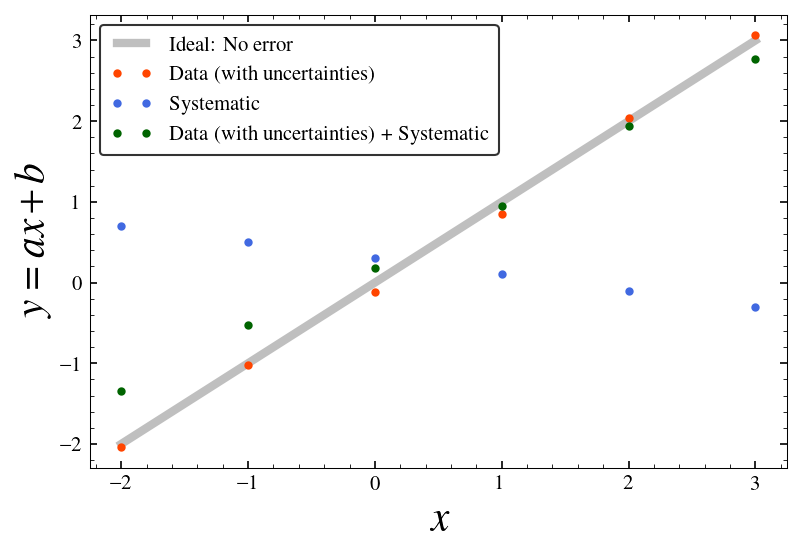

In [117]:
use_parameter_shifts_for_sys_errors = 1
if use_parameter_shifts_for_sys_errors:
    asys = -0.2 #-0.05 #-0.05 #-0.05
    bsys = 0.3 #0. #-.2
else:
    std_error_frac_for_sys = 10.
    asys = bsys = None
    
if use_parameter_shifts_for_sys_errors:
    ysys = get_data(x, asys, bsys)
else:
    #ysys = (afid+std_error * std_error_frac_for_sys) * x +  (bfid+ std_error * std_error_frac_for_sys)
    ysys = np.ones(reclen) + std_error * std_error_frac_for_sys
    
if (0): #just do some random sys error
    ysys = np.asarray( [.1, -.3, .2, -.4, .1, 0.] )
    
    
if (1): #plot data, error, and sys shift
    ax = subplot(111)
    yfid = get_data(x, afid, bfid, err = None)
    yact = get_data(x, afid, bfid, err = std_error)
    plot(x, yfid, label = r'Ideal: No error', color = 'gray', ls = '-', alpha = 0.5, lw = 4.)
    plot(x, yact, label = r'Data (with uncertainties)', color = 'orangered', marker = '.', ls = 'None')
    plot(x, ysys, label = r'Systematic', color = 'royalblue', marker = '.', ls = 'None')
    plot(x, yact+ysys, label = r'Data (with uncertainties) + Systematic', color = 'darkgreen', marker = '.', ls = 'None')  
    legend(loc = 2, fontsize = 10)
    xlabel(r'$x$', fontsize = 20); ylabel(r'$y = ax + b$', fontsize = 20)    
    show()

# Now let us use Fisher to predict the bias and see if that predcition fits the observed green data points.

In [121]:
#calculate bias vector
#Eq.(8) of https://arxiv.org/pdf/0710.5171.pdf

bias_vector = []
for pcntr, p in enumerate( params ):
    curr_bias_vector = []
    for i in range(reclen):
        der1_vec = np.asarray( [ysys[i]] )
        der2_vec = np.asarray( [der_dic[p][i]] )
        inv_cov_mat = curr_sigma**-2.
        curr_bias_val = np.dot(der1_vec, np.dot( inv_cov_mat, der2_vec ))
        curr_bias_vector.append(curr_bias_val)
    bias_vector.append( np.sum(curr_bias_vector) )
bias_vector = np.asarray(bias_vector)
final_bias_vector = np.asarray( np.dot( np.mat(bias_vector), fisher_C_mat ) )[0]
final_bias_dic = {}
for p, b in zip(params, final_bias_vector):
    final_bias_dic[p] = b
print(final_bias_vector)

#let's get a fit from Fisher bias prediction now.
ysyspred = get_data(x, final_bias_vector[0], final_bias_vector[1])
ypred = get_data(x, afid + final_bias_vector[0], bfid + final_bias_vector[1])


[-0.2  0.3]


/var/folders/08/mkcy0rls72j2q09krs7qx2jw0000gn/T/ipykernel_45005/29954647.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(111)


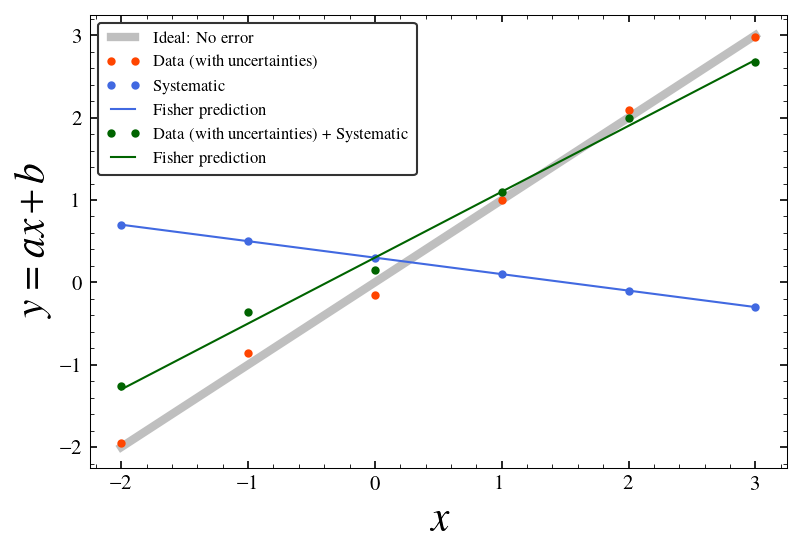

In [125]:

if (1): #plot data, error, and sys shift
    ax = subplot(111)
    yfid = get_data(x, afid, bfid, err = None)
    yact = get_data(x, afid, bfid, err = std_error)
    ax = subplot(111)
    plot(x, yfid, label = r'Ideal: No error', color = 'gray', ls = '-', alpha = 0.5, lw = 4.)
    plot(x, yact, label = r'Data (with uncertainties)', color = 'orangered', marker = '.', ls = 'None')
    plot(x, ysys, label = r'Systematic', color = 'royalblue', marker = '.', ls = 'None')
    plot(x, ysyspred, label = r'Fisher prediction', color = 'royalblue', ls = '-')  
    plot(x, yact+ysys, label = r'Data (with uncertainties) + Systematic', color = 'darkgreen', marker = '.', ls = 'None')  
    plot(x, ypred, label = r'Fisher prediction', color = 'darkgreen', ls = '-')  
    legend(loc = 2, fontsize = 8)
    xlabel(r'$x$', fontsize = 20); ylabel(r'$y = ax + b$', fontsize = 20)    
    show()